# Многоклассовая классификация
## Сведение к бинарной задаче

Мы уже подробно изучили задачу бинарной классификации, и поэтому вполне
естественно попытаться свести многоклассовую задачу к набору бинарных. Существует достаточно много способов сделать это, мы перечислим лишь два самых
популярных способа. 
* ### One-vs-All

Обучим $K$ линейных классификаторов $b_1(x),\dots,b_K(x)$,
выдающих оценки принадлежности классам $1,\dots,K$ соответственно. Например, в
случае с линейными моделями эти модели будут иметь вид 
Классификатор с номером $j$ будем обучать отличать $j$-й класс от всех остальных.
Итоговый классификатор будет выдавать класс, соответствующий самому уверенному из бинарных алгоритмов:
$$
a(x)=\text{argmax}_{j \in\{1,\dots K\}}b_j(x)
$$

Проблема данного подхода заключается в том, что каждый из классификаторов $b_1(x),\dots,b_K(x)$ обучается на своей выборке, и выходы этих классификаторов
могут иметь разные масштабы, из-за чего сравнивать их будет неправильно. Нормировать вектора весов, чтобы они выдавали ответы в одной и той же шкале, не
всегда может быть разумным решением так, в случае с SVM веса перестанут являться решением задачи, поскольку нормировка изменит норму весов.

* ### One-vs-One

Обучим $C^2_K$ классификаторов $a_{ij}(x), i, j =
= 1, . . . ,K, i \ne j$. Например, в случае с линейными моделями эти модели будут
иметь вид \eq{00}. Классификатор $a_{ij}(x)$ будем настраивать по подвыборке $X_{i,j} \in X$, содержащей только
объекты классов $i$ и $j$.

Соответственно, классификатор $a_{ij}(x)$ будет выдавать для любого объекта либо
класс $i$, либо класс $j$.
Чтобы классифицировать новый объект, подадим его на вход каждого из построенных бинарных классификаторов. Каждый из них проголосует за своей класс;
в качестве ответа выберем тот класс, за который наберется больше всего голосов:
$$
a(x)=\text{argmax}_{k \in\{1,\dots K\}}\sum_{i=1}^{K}\sum_{j\ne i}\left[a_ij(x)=k\right]
$$

Некоторые методы бинарной классификации можно напрямую обобщить на
случай многих классов. К таким методам относят логистическую регрессию и метод опорных векторов.

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import svm, datasets

In [0]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out



Будем работать с очень известным [датасетом](https://en.wikipedia.org/wiki/Iris_flower_data_set):

In [0]:
iris = datasets.load_iris()
print(iris.feature_names,iris.target_names)
X = iris.data[:, :2] # будем использовать только два признака.
y = iris.target

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] ['setosa' 'versicolor' 'virginica']


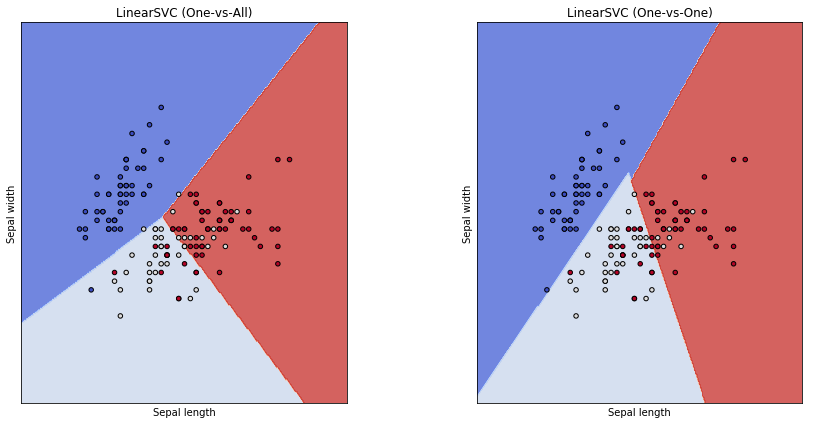

In [0]:

models = (svm.LinearSVC(C=1.0, max_iter=10000),svm.SVC(kernel='linear',C=1.0),)

models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('LinearSVC (One-vs-All)','LinearSVC (One-vs-One)',)

fig, sub = plt.subplots(1, 2,figsize=(14,7))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

## Метрики качества
В многоклассовых задачах, как правило, стараются свести подсчет качества к
вычислению одной из рассмотренных ранее двухклассовых метрик. Выделяют два
подхода к такому сведению: микро- и макро-усреднение.
Пусть выборка состоит из $K$ классов. Рассмотрим $K$ двухклассовых задач, каждая из которых заключается в отделении своего класса от остальных ("One-vs-All"). Для каждой из них можно
вычислить различные характеристики ($TP$, $FP$, и т.д.) алгоритма $a_k(x) =\left[a(x) = k\right]$;
будем обозначать эти величины как $TP_k$, $FP_k$, $FN_k$,$TN_k$. Заметим, что в двухклас-
совом случае все метрики качества, которые мы изучали, выражались через эти
элементы матрицы ошибок.
При микро-усреднении сначала эти характеристики усредняются по всем классам, а затем вычисляется итоговая двухклассовая метрика; например, точность,
полнота или F-мера. Например, точность будет вычисляться по формуле
$$
pr(a,X)=\frac{\overline{TP}}{\overline{TP}+\overline{FP}},
$$
где, например, $\bar{TP}$ вычисляется по формуле
$$\overline{TP} =\frac{1}{K}\sum_{k=1}^K TP_k. $$

При макро-усреднении сначала вычисляется итоговая метрика для каждого
класса, а затем результаты усредняются по всем классам. Например, точность будет
вычислена как
$$
pr(a,X) =\frac{1}{K}\sum_{k=1}^K pr(a_k,X)=\frac{1}{K}\sum_{k=1}^K \frac{TP_k}{TP_k+FP_k}.
$$
Если какой-то класс имеет очень маленькую мощность, то при микро-
усреднении он практически никак не будет влиять на результат, поскольку его вклад
в средние $TP$, $FP$, $FN$ и $TN$ будет незначителен. В случае же с макро-вариантом
усреднение проводится для величин, которые уже не чувствительны к соотношению
размеров классов (если мы используем, например, точность).

In [0]:
from sklearn import metrics

In [0]:
models = (svm.LinearSVC(C=1.0, max_iter=10000),svm.SVC(kernel='linear',C=1.0),)

models = (clf.fit(X, y) for clf in models)

for clf, title in zip(models,titles):
    y_pred=clf.predict(X)
    print(title)
    print('Micro:')
    print (metrics.precision_score(y,y_pred,average='micro'))
    print (metrics.recall_score(y,y_pred,average='micro'))

    print('Macro:')
    print (metrics.precision_score(y,y_pred,average='macro'))
    print (metrics.recall_score(y,y_pred,average='macro'))

LinearSVC (One-vs-All)
Micro:
0.8
0.8
Macro:
0.8018998559875928
0.7999999999999999
LinearSVC (One-vs-One)
Micro:
0.82
0.82
Macro:
0.8205539943797672
0.82


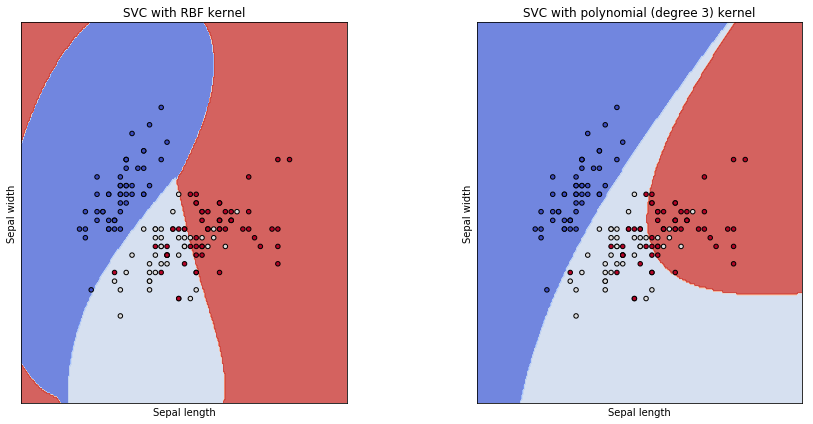

In [0]:
models = (svm.SVC(kernel='rbf', gamma=0.7, C=1.0),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=1.0))

models = (clf.fit(X, y) for clf in models)
titles = ('SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')


fig, sub = plt.subplots(1, 2,figsize=(14,7))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

In [0]:
models = (svm.SVC(kernel='rbf', gamma=0.7, C=1.0),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=1.0))

models = (clf.fit(X, y) for clf in models)
titles = ('SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

for clf, title in zip(models,titles):
    y_pred=clf.predict(X)
    print(title)
    print('Micro:')
    print (metrics.precision_score(y,y_pred,average='micro'))
    print (metrics.recall_score(y,y_pred,average='micro'))

    print('Macro:')
    print (metrics.precision_score(y,y_pred,average='macro'))
    print (metrics.recall_score(y,y_pred,average='macro'))

SVC with RBF kernel
Micro:
0.8266666666666667
0.8266666666666667
Macro:
0.8266666666666667
0.8266666666666667
SVC with polynomial (degree 3) kernel
Micro:
0.8133333333333334
0.8133333333333334
Macro:
0.8142780461621042
0.8133333333333334


Загружаем данные для распознавания рукописных цифр.Всего данные содержат 1797 рукописных цифр от 0 до 9 (10 классов):

In [0]:
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data
y = digits.target
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


Каждая рукописная цифра содержит информацию о 64 пикселях ее изображения:

In [0]:
digits.images[10]

array([[ 0.,  0.,  1.,  9., 15., 11.,  0.,  0.],
       [ 0.,  0., 11., 16.,  8., 14.,  6.,  0.],
       [ 0.,  2., 16., 10.,  0.,  9.,  9.,  0.],
       [ 0.,  1., 16.,  4.,  0.,  8.,  8.,  0.],
       [ 0.,  4., 16.,  4.,  0.,  8.,  8.,  0.],
       [ 0.,  1., 16.,  5.,  1., 11.,  3.,  0.],
       [ 0.,  0., 12., 12., 10., 10.,  0.,  0.],
       [ 0.,  0.,  1., 10., 13.,  3.,  0.,  0.]])

0


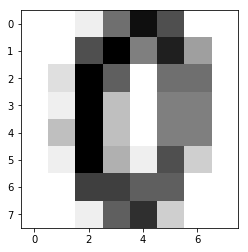

In [0]:
plt.imshow(digits.images[10],cmap='binary') 
print(y[10])

Информация об интенсивностях каждого пикселя и будет признаковое описание соответствующей цифры (построчно):

In [0]:
print(X[0],y[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.] 0


Разделим выборку на обучающую и тестовую:

In [0]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.33, 
                                                    random_state = 7)

Определим гиперпараметры классификатора SVM по перекрестной проверке, используя GridSearch:

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
svm.SVC().get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [0]:
params = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
    {'C': [1, 10, 100, 1000], 'degree': [3, 5], 'kernel': ['poly']}
 ]


grid = GridSearchCV(svm.SVC() , param_grid = params) 
grid.fit(X_train, y_train)

print (grid.best_estimator_.C,grid.best_estimator_.kernel) # находим оптимальное значение параметра С

10 rbf


In [0]:
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

In [0]:
from sklearn import metrics
print('Micro:')
print (metrics.precision_score(y_test,y_pred,average='micro'))
print (metrics.recall_score(y_test,y_pred,average='micro'))

print('Macro:')
print (metrics.precision_score(y_test,y_pred,average='macro'))
print (metrics.recall_score(y_test,y_pred,average='macro'))

Micro:
0.9915824915824916
0.9915824915824916
Macro:
0.9913792740884049
0.9922848847223248


In [0]:
A=metrics.confusion_matrix(y_test,y_pred)
print(A)

[[63  0  0  0  0  0  0  0  0  0]
 [ 0 57  0  0  0  0  0  0  0  0]
 [ 0  0 57  0  0  0  0  0  0  0]
 [ 0  0  0 56  0  0  0  0  0  1]
 [ 0  0  0  0 64  0  0  0  0  0]
 [ 0  0  0  0  0 51  0  0  0  0]
 [ 0  0  0  0  0  0 56  0  0  0]
 [ 0  0  0  0  0  0  0 58  0  0]
 [ 0  2  0  0  0  0  0  1 66  0]
 [ 0  0  0  0  0  1  0  0  0 61]]


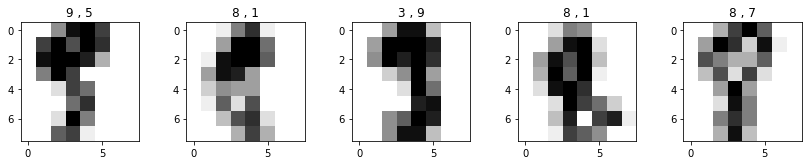

In [0]:
fig, sub = plt.subplots(1, 5,figsize=(14,7))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

j=0
for i in range(len(y_pred)):
    if(y_pred[i]!=y_test[i]):
        Img=X_test[i].reshape(8,8)
        sub[j].imshow(Img,cmap='binary')
        sub[j].set_title(str(y_test[i])+' , '+str(y_pred[i]))
        j=j+1

## Pipeline 

 Класс [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) позволяет “склеивать” несколько операций обработки данных в единую модель библиотеки scikit-learn. Класс Pipeline предусматривает методы fit, predict и score и имеет все те же свойства, что и любая модель в библиотеке scikit-learn. Чаще всего класс Pipeline используется для объединения операций предварительной обработки (например, масштабирования
данных) с моделью контролируемого машинного обучения типа классификатора.

Давайте посмотрим, как мы можем использовать класс Pipeline, чтобы
осуществить обучение SVM-модели после масштабирования данных с помощью класса StandartScaler.

In [0]:
X = iris.data 
y = iris.target
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 7)

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scale_clf=Pipeline([
    ('scaler', StandardScaler()),
    ('clf', svm.LinearSVC(C=1.0, max_iter=10000))])

In [0]:
scale_clf.fit(X_train, y_train)
print(scale_clf.score(X_test, y_test))

0.7333333333333333


"Короткая" версия модели присваевает имена этапов автоматически:

In [0]:
from sklearn.pipeline import make_pipeline

scale_clf2=make_pipeline(StandardScaler(),svm.LinearSVC(C=1.0, max_iter=10000))

In [0]:
scale_clf2.steps

[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('linearsvc',
  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
       intercept_scaling=1, loss='squared_hinge', max_iter=10000,
       multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
       verbose=0))]

In [0]:
pipe_svm=Pipeline([
    ('scaler', StandardScaler()),
    ('clf', svm.LinearSVC())])

params = {'clf__C':[0.1,1,10,100]}

grid = GridSearchCV(pipe_svm, param_grid = params,cv=2) 
grid.fit(X_train, y_train)


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [0]:
print(grid.best_params_)

{'clf__C': 10}


In [0]:
grid.score(X_test,y_test)

0.8